In [32]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

In [2]:
ldom = np.array([[46, 48],[-125.0, -123.8]])
qbox = np.array([[-124.5,-124,-124.3,-124.8,-124.5],[46.5,46.5,47.5,47.5,46.5]])
fecha=['2000-01-01','2019-12-31']

In [3]:
# SST
ds2 = xr.open_dataset('../data/timeseries_sst_mur_01km.nc')
ds2.close()
# average averages, and variability
ds = ds2.sel(lon=slice(ldom[1,0],ldom[1,1]),lat=slice(ldom[0,0],ldom[0,1]))
ds

<xarray.Dataset>
Dimensions:           (lat: 201, lon: 121, time: 212)
Coordinates:
  * time              (time) datetime64[ns] 2002-06-30 2002-07-31 ... 2020-01-31
  * lon               (lon) float32 -125.0 -124.99 -124.98 ... -123.81 -123.8
  * lat               (lat) float32 46.0 46.01 46.02 46.03 ... 47.98 47.99 48.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...

<xarray.DataArray (lon: 121, lat: 201)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -125.0 -125.0 -125.0 -125.0 ... -123.8 -123.8 -123.8
  * lat      (lat) float64 46.0 46.01 46.02 46.03 ... 47.97 47.98 47.99 48.0


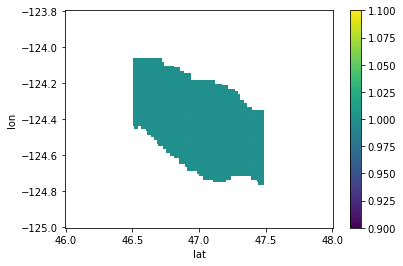

In [4]:
mask = xr.open_dataarray('./QIN_mask.nc')
mask.close()

mask = mask.rename({'x':'lon','y':'lat'})
# interpolate like SST
sst_mask = mask.interp_like(ds)
print(sst_mask)
sst_mask.plot()

In [5]:

#get bathymetry from ETOPO1
fname_topo = '~/Documents/LargeData/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fname_topo)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))

x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [6]:
sst=ds.analysed_sst*sst_mask
sst

<xarray.DataArray (time: 212, lat: 201, lon: 121)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-06-30 2002-07-31 ... 2020-01-31
  * lon      (lon) float32 -125.0 -124.99 -124.98 ... -123.82 -123.81 -123.8
  * lat      (lat) float32 46.0 46.01 46.02 46.03 ... 47.97 47.98 47.99 48.0

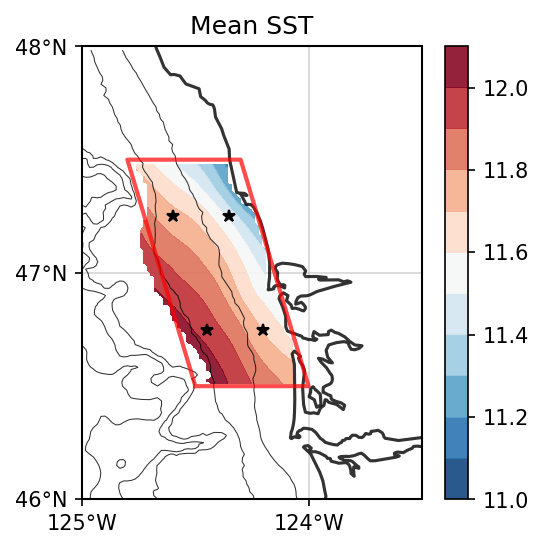

In [27]:
sel = np.array([[-124.6,-124.35,-124.45,-124.2],[47.25,47.25,46.75,46.75]])
ldom = np.array([[46, 48],[-125, -123.5]])
msst = sst.mean('time') - 273.15
fig=plt.figure(figsize=(4,4),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
ax.set_xticks([*np.arange(ldom[1,0],ldom[1,1]+0.5,1)], crs=ccrs.PlateCarree())
ax.set_yticks([*np.arange(ldom[0,0],ldom[0,1]+1,1)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=0,alpha=0.5)
#ax.set_aspect(1.5)
plt.contour(X,Y,topo2,[-1000,-500,-200,-100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.8)
plt.contourf(msst.lon, msst.lat,msst, levels=[*np.arange(11,12.2,.1)],cmap='RdBu_r', zorder=2, alpha=0.9)
plt.plot(qbox[0,:],qbox[1,:],c='r',lw=2,zorder=5, alpha=0.7)
plt.plot(sel[0,:],sel[1,:], '*k')
plt.title('Mean SST')
plt.colorbar()
plt.savefig('./AnnualSSTmean_1km_QIN.png')
plt.show()

In [29]:
sst_ts_mean = sst.mean(dim={'lat','lon'})-273.15
sst_ts_std = sst.std(dim={'lat','lon'})
sst_ts_max = sst.max(dim={'lat','lon'})-273.15
sst_ts_min = sst.min(dim={'lat','lon'})-273.15

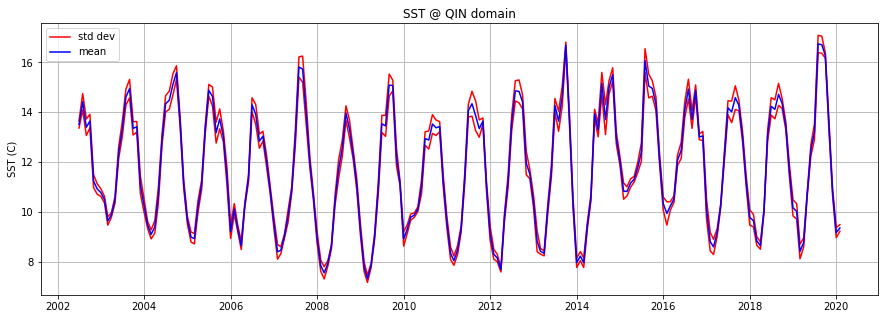

In [30]:
plt.figure(figsize=(15,5))
#plt.plot(sst_ts_mean.time,sst_ts_max,'r')
#plt.plot(sst_ts_mean.time,sst_ts_min,'r', label='max-min')
plt.plot(sst_ts_mean.time,sst_ts_mean+sst_ts_std,'r')
plt.plot(sst_ts_mean.time,sst_ts_mean-sst_ts_std,'r',label='std dev')
plt.plot(sst_ts_mean.time,sst_ts_mean,'b',label='mean')
plt.ylabel('SST (C)')
plt.legend()
plt.title('SST @ QIN domain')
plt.grid()
plt.savefig('./MonthlymeanSSTtimeseries_1km_QIN.png')


In [35]:
# time series around selected points
sst_pts_mean = np.full((len(sst.time.values),4),np.nan)
sst_pts_std = np.full((len(sst.time.values),4),np.nan)
for i in range(4):
    print(sel[0,i],sel[1,i])
    tmp = sst.sel(lat=slice(sel[1,i]-0.1,sel[1,i]+0.1),lon=slice(sel[0,i]-0.1,sel[0,i]+0.1))
    sst_pts_mean[:,i] = tmp.mean(dim={'lat','lon'})-273.15
    sst_pts_std[:,i] = tmp.mean(dim={'lat','lon'})

-124.6 47.25
-124.35 47.25
-124.45 46.75
-124.2 46.75


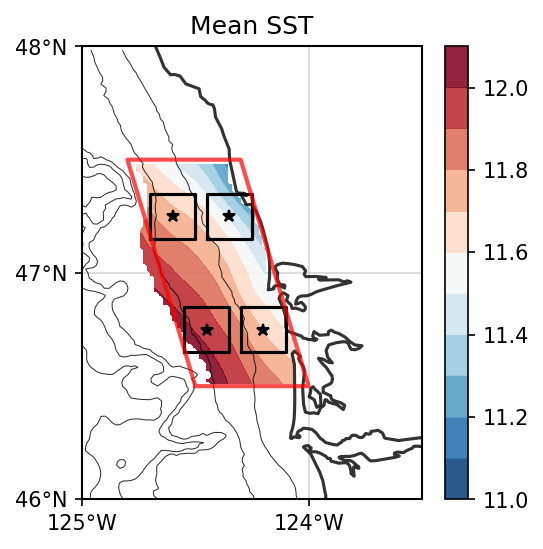

In [36]:
sel = np.array([[-124.6,-124.35,-124.45,-124.2],[47.25,47.25,46.75,46.75]])
ldom = np.array([[46, 48],[-125, -123.5]])
msst = sst.mean('time') - 273.15
fig=plt.figure(figsize=(4,4),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=1.5,color='black',alpha=0.8,zorder=4)
ax.set_extent([ldom[1,0],ldom[1,1],ldom[0,0],ldom[0,1]],crs=ccrs.PlateCarree())
ax.set_xticks([*np.arange(ldom[1,0],ldom[1,1]+0.5,1)], crs=ccrs.PlateCarree())
ax.set_yticks([*np.arange(ldom[0,0],ldom[0,1]+1,1)], crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.grid(True, zorder=0,alpha=0.5)
#ax.set_aspect(1.5)
plt.contour(X,Y,topo2,[-1000,-500,-200,-100,-50],colors='k',linewidths=0.5, linestyles='solid', zorder=3, alpha=0.8)
plt.contourf(msst.lon, msst.lat,msst, levels=[*np.arange(11,12.2,.1)],cmap='RdBu_r', zorder=2, alpha=0.9)
plt.plot(qbox[0,:],qbox[1,:],c='r',lw=2,zorder=5, alpha=0.7)
for i in range(4):
    plt.plot(sel[0,i],sel[1,i], '*k')
    # box
    plt.plot([sel[0,i]-0.1,sel[0,i]+0.1,sel[0,i]+0.1,sel[0,i]-0.1,sel[0,i]-0.1],[sel[1,i]-0.1,sel[1,i]-0.1,sel[1,i]+0.1,sel[1,i]+0.1,sel[1,i]-0.1],'k')
plt.title('Mean SST')
plt.colorbar()
plt.savefig('./AnnualSSTmean_1km_QIN_points.png')
plt.show()

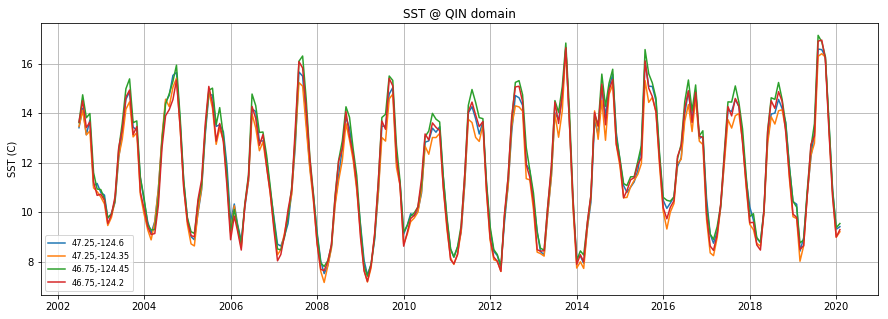

In [37]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(sst.time,sst_pts_mean[:,i],label=str(sel[1,i])+','+str(sel[0,i]))
plt.ylabel('SST (C)')
plt.legend(fontsize='small')
plt.title('SST @ QIN domain')
plt.grid()
plt.savefig('./MonthlymeanSSTtimeseries_4pts_QIN.png')


In [38]:
# save data
d={'Date':sst.time.values,'QIN_mean':sst_ts_mean,'QIN_std':sst_ts_std,'QIN_max':sst_ts_max,'QIN_min':sst_ts_min,
   'P1:47.25N,124.6W_mean':sst_pts_mean[:,0],'P1:47.25N,124.6W_std':sst_pts_std[:,0],
   'P1:47.25N,124.35W_mean':sst_pts_mean[:,1],'P1:47.25N,124.6W_std':sst_pts_std[:,1],
   'P1:46.75N,124.45W_mean':sst_pts_mean[:,2],'P1:47.25N,124.6W_std':sst_pts_std[:,2],
   'P1:46.75N,124.2W_mean':sst_pts_mean[:,3],'P1:47.25N,124.6W_std':sst_pts_std[:,3],
  }
df = pd.DataFrame(data=d)
df.to_csv('./QIN_MUR_SST_montimeseries.csv')
df

,Date,QIN_mean,QIN_std,QIN_max,QIN_min,"P1:47.25N,124.6W_mean","P1:47.25N,124.6W_std","P1:47.25N,124.35W_mean","P1:46.75N,124.45W_mean","P1:46.75N,124.2W_mean"
0,2002-06-30,13.506519,0.139466,13.804437,13.097986,13.406973,286.788532,13.457454,13.611435,13.638532
1,2002-07-31,14.422850,0.324344,15.076318,13.605310,14.193808,287.648578,14.107318,14.737845,14.498578
2,2002-08-31,13.399479,0.333186,14.300653,12.711084,13.125198,286.562434,13.118473,13.811722,13.412434
3,2002-09-30,13.645973,0.268756,14.219720,12.808374,13.720153,286.787679,13.276972,13.982123,13.637679
4,2002-10-31,11.239262,0.256450,11.815057,10.631921,11.053186,284.369080,10.979476,11.593920,11.219080
5,2002-11-30,10.927566,0.210676,11.476587,10.459283,11.155823,283.824844,10.828782,10.929453,10.674844
6,2002-12-31,10.778757,0.152235,11.048212,10.313928,10.796067,283.871977,10.609487,10.909767,10.721977
7,2003-01-31,10.500822,0.133768,10.740381,10.108209,10.684190,283.628917,10.325719,10.528971,10.478917
8,2003-02-28,9.641057,0.167078,9.995233,9.267786,9.747645,282.687662,9.455515,9.773802,9.537662
9,2003-03-31,9.886961,0.088621,10.033472,9.577417,9.937886,283.041681,9.784366,9.920077,9.891681


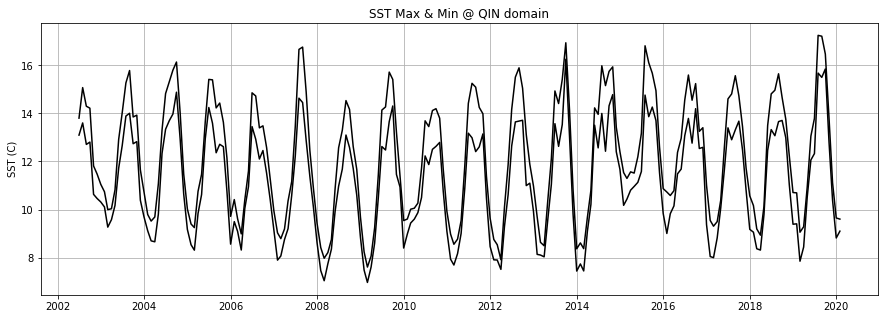

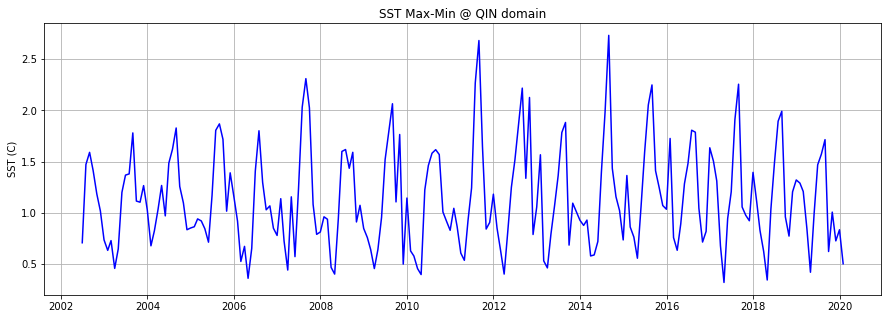

In [86]:
plt.figure(figsize=(15,5))
plt.plot(sst_ts_mean.time,sst_ts_max,'k')
plt.plot(sst_ts_mean.time,sst_ts_min,'k', label='max-min')
plt.ylabel('SST (C)')
plt.title('SST Max & Min @ QIN domain')
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(sst_ts_mean.time,sst_ts_max-sst_ts_min,'b', label='max-min')
plt.ylabel('SST (C)')
plt.title('SST Max-Min @ QIN domain')
plt.grid()
plt.savefig('./MonthlySSTmaxmintimeseries_1km_QIN.png')
plt.show()

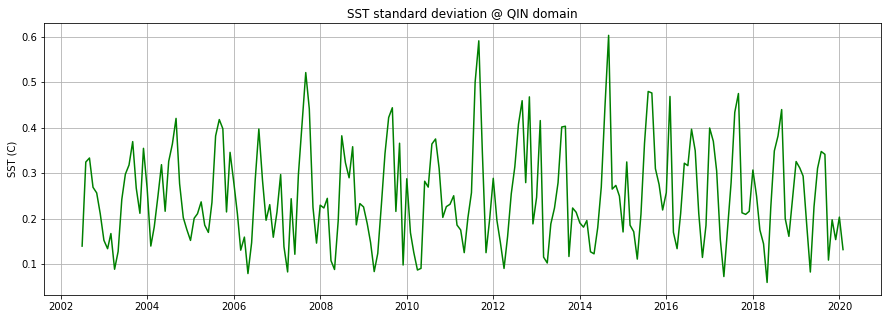

In [33]:
plt.figure(figsize=(15,5))
plt.plot(sst_ts_mean.time,sst_ts_std,'g')
plt.ylabel('SST (C)')
plt.title('SST standard deviation @ QIN domain')
plt.grid()
plt.savefig('./MonthlySSTstdevtimeseries_1km_QIN.png')
plt.show()

In [36]:
allsst=sst.values.ravel()
allsst=allsst[~np.isnan(allsst)]-273.15

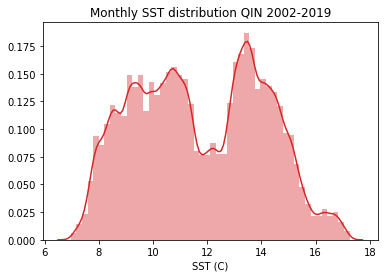

In [38]:
sns.distplot(allsst, color='tab:red')
plt.title('Monthly SST distribution QIN 2002-2019')
plt.xlabel('SST (C)')
plt.savefig('./MonthlySSTdistribution_1km_QIN.png')
plt.show()

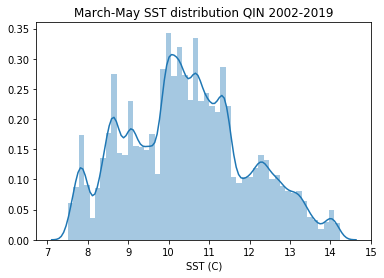

In [57]:
#allsst2=sst.sel(time.month=slice(3,5)).values.ravel()
#allsst2=allsst[~np.isnan(allsst)]-273.15
tmp=sst.where((sst.time.dt.month<6)&(sst.time.dt.month>2))
allsst_crab=tmp.values.ravel()
allsst_crab=allsst_crab[~np.isnan(allsst_crab)]-273.15
sns.distplot(allsst_crab, color='tab:blue')
plt.title('March-May SST distribution QIN 2002-2019')
plt.xlabel('SST (C)')
plt.savefig('./Monthly_MarchMay_SSTdistribution_1km_QIN.png')
plt.show()

In [39]:
clim = sst_ts_mean.groupby('time.month').mean('time',keep_attrs=True)
ssta = sst_ts_mean.groupby('time.month') - clim

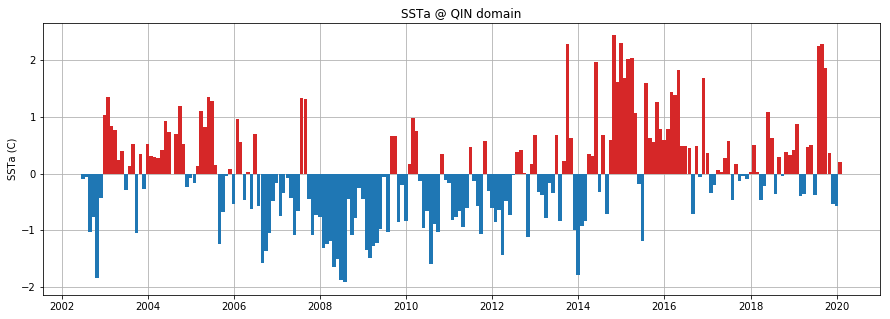

In [40]:
plt.figure(figsize=(15,5))
n1=ssta.where(ssta>=0,other=0)
n2=ssta.where(ssta<0,other=0)
plt.bar(n1.time.values,n1,width=30,color='tab:red',zorder=2, edgecolor=None)
plt.bar(n2.time.values,n2,width=30,color='tab:blue',zorder=2, edgecolor=None)
#plt.plot(ssta.time,ssta,'tab:red',label='mean')
plt.ylabel('SSTa (C)')
plt.title('SSTa @ QIN domain')
plt.grid(zorder=1)
plt.savefig('./MonthlySSTanomtimeseries_1km_QIN.png')
plt.show()

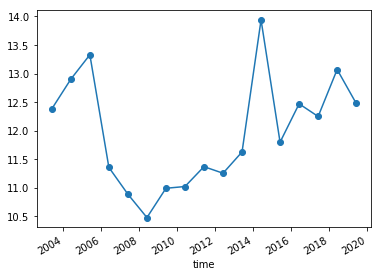

In [83]:
sst_ts_mean[ssta.month==5].plot(marker='o')


In [131]:
# hovemuller
ssta_hm=np.full((2020-2002+1,12),np.nan)
ssta_hm[0,5:]=ssta.values[:7]
ssta_hm[-1,0]=ssta.values[-1]
ssta_hm[1:-1,:]=ssta.values[7:-1].reshape(2019-2003+1,12)

sst_hm=np.full((2020-2002+1,12),np.nan)
sst_hm[0,5:]=sst_ts_mean.values[:7]
sst_hm[-1,0]=sst_ts_mean.values[-1]
sst_hm[1:-1,:]=sst_ts_mean.values[7:-1].reshape(2019-2003+1,12)

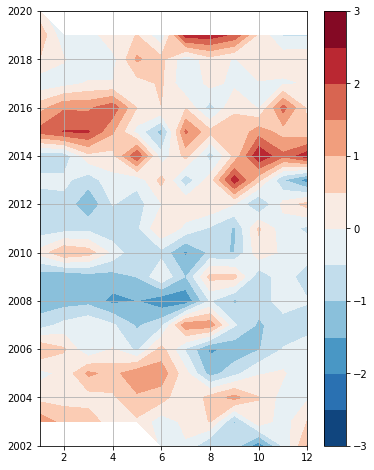

In [134]:
plt.figure(figsize=(6,8))
plt.contourf(range(1,13),range(2002,2021),ssta_hm, levels=[*np.arange(-3,3.1,.5)], cmap='RdBu_r', vmax=3.,vmin=-3.)
plt.colorbar()
plt.grid()
plt.show()

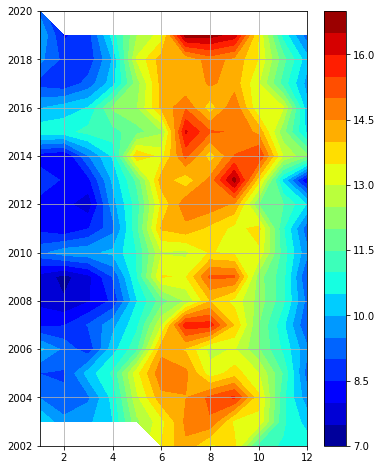

In [139]:
plt.figure(figsize=(6,8))
plt.contourf(range(1,13),range(2002,2021),sst_hm, levels=[*np.arange(7,17.5,0.5)], cmap='jet')
plt.colorbar()
plt.grid()
plt.show()